Initial Number of Candidates: 820
Restrict Fitting of Candidates: 246
Restrict to Have All Filters Number of Candidates: 122
Number of Candidates: 122


Text(0.5, 1.0, 'Synthetic SED Examples')

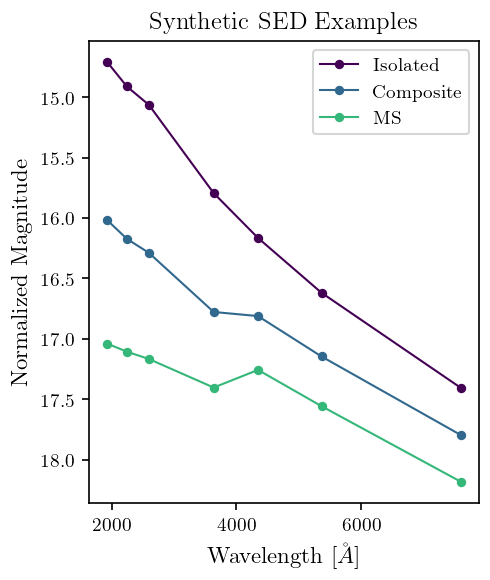

In [3]:
import pandas as pd 
import numpy as np
import glob
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp # pip install mycolorpy
import tabula,re,os
import matplotlib
data_dir = os.getenv("DATADIR")
plt.style.use(data_dir+'bl.mplstyle')
# use rcparams to adjust marker size
matplotlib.rcParams['lines.markersize'] = 3.5

#########
# Paths # 
#########
flux_fraction_file = data_dir + '1_Models/StrippedStars/flux_contribution_CMFGEN_composites.txt'
synthetic_photometry_file = data_dir+'1_Models/StrippedStars/COMBINED_photometry_CMFGEN_composites_apparent_Gotberg.csv'
sed_fit_candidate_file = data_dir + '0_SUMS_Catalogs/CandidateCatalog/4_stripped_star_candidates_fit.csv'
model_dir = data_dir+'1_Models/Ludwig25/'
model_meta_file = model_dir+'ModelMeta.csv'

#############
# FUNCTIONS # 
#############
def find_closest_masses(mass, mass_label,model_meta_file=model_meta_file):
    file_df = pd.read_csv(model_meta_file)
    closest_mass = file_df.loc[(file_df[mass_label] - mass).abs().argmin(),mass_label]
    if  mass - closest_mass > 0.5:
        print(f'Warning: Closest mass is {closest_mass} but you are {mass} away')
    return closest_mass

def get_model_seds(stripped_mass, ms_mass,model_meta_file=model_meta_file): 
    names = ['Wavelength','Flambda','Fcont']
    # Had to be extra because number -> string leaves off 0's
    file_df = pd.read_csv(model_meta_file)
    stripped_filename = file_df.loc[file_df.s_mass == find_closest_masses(stripped_mass,'s_mass'),'s_fname'].values[0].replace("\\","/")
    stripped = pd.read_csv(model_dir+stripped_filename,delimiter=',')
    stripped.columns = names
     # Restrict wavelength to 1928 - 7609
    stripped = stripped[(stripped['Wavelength'] > 1928) & (stripped['Wavelength'] < 7609)]
    if ms_mass == 0:
        return stripped
    ms_filename = file_df.loc[file_df.m_mass == find_closest_masses(ms_mass,'m_mass'),'m_fname'].values[0].replace("\\","/")
    ms = pd.read_csv(model_dir+ms_filename,delimiter=',')
    ms.columns = names
    c_filename = file_df.loc[(file_df.c_strip == find_closest_masses(stripped_mass,'c_strip')) & (file_df.c_ms == find_closest_masses(ms_mass,'c_ms')),'c_fname'].values[0].replace("\\","/")
    comp = pd.read_csv(model_dir+c_filename,delimiter=',')
    comp.columns = names
    # Restrict wavelength to 1928 - 7609
    ms = ms[(ms['Wavelength'] > 1928) & (ms['Wavelength'] < 7609)]
    comp = comp[(comp['Wavelength'] > 1928) & (comp['Wavelength'] < 7609)]
    return stripped, ms, comp

# Function to convert fluxes to magnitudes
def convert_flux_to_mag(model,scale_by=18):
    mags = -2.5 * np.log10(model['Flambda'])
    if scale_by:
        mags = mags - np.min(mags) + scale_by
    return mags

#Approximate central wavelengths in angstroms
eff_wav = [1928,2246,2600,3639.3,4350.6,5369.6,7609.2] 
# Columns for sed 
errors = ['uvw2_err','uvm2_err','uvw1_err','e_U','e_B','e_V','e_I']
mags = ['uvw2_dered','uvm2_dered','uvw1_dered','U_dered','B_dered','V_dered','I_dered']
# Galactic distances 
smc_distance = 60.6e3
lmc_distance = 50e3


#############
# Synthetic #
#############
# Read in flux fractions
df_ff = pd.read_csv(flux_fraction_file,comment='#',delimiter='\t',names=['Minit_strip','M_MS','frac_MS', 'frac_B', 'frac_V', 'frac_R', 'frac_UVM2', 'frac_UVW2', 'frac_UVW1'])

# Add cases where there is no MS 
zeros = []
for Minit in df_ff['Minit_strip'].unique():
		zero_dict = {'Minit_strip':Minit,'M_MS':0.0,'frac_MS':0.0,'frac_B':1.0,'frac_V':1.0,'frac_R':1.0,'frac_UVM2':1.0,'frac_UVW2':1.0,'frac_UVW1':1.0}
		zeros.append(zero_dict)
		
df_ff = pd.concat([df_ff,pd.DataFrame(zeros)],ignore_index=True)

df_ff = df_ff.drop_duplicates().reset_index(drop=True)

df_ph = pd.read_csv(synthetic_photometry_file)
df_ph = df_ph.rename(columns={'Mstrip':'M_strip','Minit':'Minit_strip'})

# Merge on Minit_strip, M_MS, and frac_MS
df_synth = pd.merge(df_ff,df_ph,how='left',on=['Minit_strip','M_MS','frac_MS'])

##############
# Candidates #
##############
# Read in candidtes
df = pd.read_csv(sed_fit_candidate_file)
print('Initial Number of Candidates:',len(df))

# Rename columns we want to merge on 
df = df.rename(columns={'fit_Minit_strip':'Minit_strip','fit_M_strip':'M_strip','fit_M_MS':'M_MS','fit_frac_MS':'frac_MS'})

# # Merge Candidates w Flux Frac on Minit_strip, M_MS, and frac_MS
df = pd.merge(df,df_ff,how='left',on=['Minit_strip','M_MS','frac_MS'])

# Only get rows where fit is good
reduced_log_likelihood = df.fit_log_likelihood / df.fit_dof
percentile = np.percentile(reduced_log_likelihood,70)
df = df[reduced_log_likelihood > percentile ]
print('Restrict Fitting of Candidates:',len(df))

# Create q_init column 
df['q_init'] = df['Minit_strip'] / df['M_MS']

# Create bend column 
df['uvw1 - u'] =  - (df['uvw1_dered'] - df['U_dered'])
df['u - b'] =  - (df['U_dered'] - df['B_dered'])
df['b - v'] =  - (df['B_dered'] - df['V_dered'])

# Make sure they have all filters 
all_filters = ['uvw2_dered', 'uvw1_dered', 'uvm2_dered', 'U_dered', 'B_dered', 'V_dered',  'I_dered']
df = df.dropna(subset=all_filters).reset_index(drop=True)
print('Restrict to Have All Filters Number of Candidates:',len(df))

# How many do we have? 
print('Number of Candidates:',len(df))

##############
# References #
##############

# Get the Zeropoints for each filter 
zp = pd.read_csv('https://waps.cfa.harvard.edu/MIST/BC_tables/zeropoints.txt',delimiter='\\s+')

# Sort synthetic photometry first by M_init_strip and then by M_MS
df_synth['q_init'] = df_synth['Minit_strip'] / df_synth['M_MS']
bend_diff = df_synth['B'] - df_synth['U']
df_synth['bend'] = bend_diff
df_synth = df_synth.sort_values(by=['Minit_strip','M_MS'])

# Make sure the stripped star isn't a subdwarf
df_synth = df_synth[df_synth['Minit_strip'] > 6]

# Make sure it isn't too faint to be a good source
df_synth = df_synth[df_synth['I'] < 18.5]

# Make sure q > 1 
df_synth = df_synth[df_synth['q_init'] > 1]

# Make sure MS isn't so evolved that it's cooling 
df_synth = df_synth[df_synth['frac_MS'] < 0.7]

df_synth = df_synth.reset_index(drop=True)

# After plotting found a few restraints that worked to get the three types of SEDS
df_synth_isolated = df_synth[(df_synth['frac_V'] > 0.88)]
df_synth_isolated = df_synth_isolated.sort_values(by='frac_V',ascending=False)

df_synth_comp = df_synth[(df_synth['frac_V'] < 0.6) & (df_synth['frac_V'] > 0.4)]
df_synth_comp = df_synth_comp.sort_values(by='frac_V',ascending=False)

df_synth_ms = df_synth[(df_synth['frac_V'] < 0.11)]
df_synth_ms = df_synth_ms.sort_values(by='frac_V',ascending=True)

# Plot one of each
fig, ax = plt.subplots(1,1,dpi=150)
colors = mcp.gen_color(cmap="viridis",n=4)

def normalize(sed):
    return sed / sed.mean()


sed_iso = df_synth.loc[df_synth_isolated.index[0],['UVW2','UVM2','UVW1','U','B','V','I']]
sed_comp = df_synth.loc[52,['UVW2','UVM2','UVW1','U','B','V','I']]
sed_ms = df_synth.loc[df_synth_ms.index[-1],['UVW2','UVM2','UVW1','U','B','V','I']]


ax.plot(eff_wav,sed_iso - 1.,'o-',color=colors[0],label='Isolated')
ax.plot(eff_wav,sed_comp - 0.5,'o-',color=colors[1],label='Composite')
ax.plot(eff_wav,sed_ms + 0.1,'o-',color=colors[2],label='MS')
ax.set_ylabel(f'Normalized Magnitude')
ax.set_xlabel('Wavelength [$\\AA$]')
ax.invert_yaxis()
ax.tick_params(axis='both', which='major')
ax.legend()
ax.set_title('Synthetic SED Examples')

<>:119: SyntaxWarning: invalid escape sequence '\m'
<>:119: SyntaxWarning: invalid escape sequence '\m'
/var/folders/v7/3cz8p5d553b7s1dcymxc7m1hdpkh95/T/ipykernel_92750/3827515904.py:119: SyntaxWarning: invalid escape sequence '\m'
  [ax.set_xlabel('Wavelength [$\mathrm{\\AA}$]') for ax in axes[1,:]]
/var/folders/v7/3cz8p5d553b7s1dcymxc7m1hdpkh95/T/ipykernel_92750/3827515904.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shift = first_val + c - sed_iso[0] + normal
/var/folders/v7/3cz8p5d553b7s1dcymxc7m1hdpkh95/T/ipykernel_92750/3827515904.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shift = first_val + 

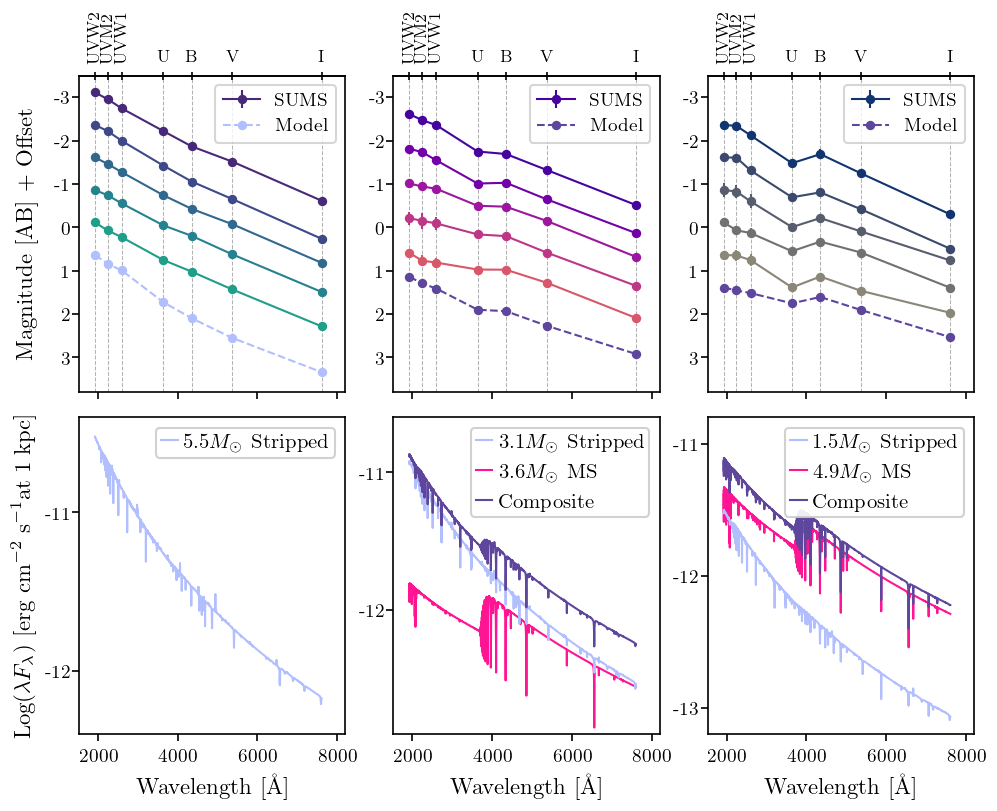

In [ ]:
sed_cols = ['uvw2_dered','uvm2_dered','uvw1_dered','U_dered','B_dered','V_dered','I_dered']
# Examples of isolated sources 
iso_keys = ['SUMS_c7449', 'SUMS_c856a', 'SUMS_cacfd', 'SUMS_bd560','SUMS_caa4e']
iso = df[df.SUMS_ID.isin(iso_keys)].copy()
iso = iso.sort_values(by='uvw2_dered').reset_index(drop=True)

# Examples of composite sources 
comp_keys = ['SUMS_c76a9','SUMS_c06e3','SUMS_c237b','SUMS_c6c27','SUMS_be690']
comp = df[df.SUMS_ID.isin(comp_keys)].copy()
comp = comp.sort_values(by='uvw2_dered').reset_index(drop=True)

ms_keys =  ['SUMS_c3b48','SUMS_3d9da','SUMS_c3a48','SUMS_c1beb','SUMS_c2fab']
ms =  df[df.SUMS_ID.isin(ms_keys)].copy()
ms = ms.sort_values(by='uvw2_dered').reset_index(drop=True)

# Get theoretical models similar to the example stars we're showing above 
iso_s_mass = 5.47 
iso_s = get_model_seds(iso_s_mass,0)

comp_s_mass = 3.10
comp_m_mass = 3.65
comp_s, comp_m, comp_c = get_model_seds(comp_s_mass, comp_m_mass)

ms_s_mass = 1.54
ms_m_mass = 4.93
ms_s, ms_m, ms_c = get_model_seds(ms_s_mass, ms_m_mass)

# COLORS 
stripped_star_color = '#B2BFFF'
main_seq_color = '#FF1593'
combined_color = '#5D469C'
isocolors = mcp.gen_color(cmap="viridis",n=iso.shape[0]+5)
compcolors = mcp.gen_color(cmap="plasma",n=comp.shape[0]+5)
mscolors = mcp.gen_color(cmap="cividis",n=ms.shape[0]+5)


f, axes = plt.subplots(2,3,dpi=150,figsize=(3.35*2+1,3.35*2-1))

#############
# FIRST ROW #
#############
# "Isolated"
ax = axes[0,0]
c = 0
normal = -21 + 3.5
first_val = iso.iloc[0][sed_cols[0]]
for ind, row in iso.iterrows():
    sed, err = row[mags].values, row[errors].values
    shift = first_val + c - sed[0] + normal
    ax.errorbar(eff_wav,sed+shift,yerr=err,marker='o',color=isocolors[ind+1],label='SUMS')
    c += 0.75
shift = first_val + c - sed_iso[0] + normal
ax.plot(eff_wav,sed_iso + shift,'o--',color=stripped_star_color,label='Model')
handles, labels = ax.get_legend_handles_labels()    
ax.legend(list(reversed(handles[0:2])),list(reversed(labels[0:2])),loc='upper right')

# "Composite"
bx = axes[0,1]
c = 0
for ind, row in comp.iterrows():
    sed, err = row[mags].values, row[errors].values
    shift = first_val + c - sed[0] + 0.5 + normal
    bx.errorbar(eff_wav,sed+shift,yerr=err,marker='o',color=compcolors[ind+1],label='SUMS')
    c += 0.8#75
    
shift = first_val + c - sed_comp[0] + 0.25 + normal
bx.plot(eff_wav,sed_comp + shift,'o--',color=combined_color,label='Model')
handles, labels = bx.get_legend_handles_labels()    
bx.legend(list(reversed(handles[0:2])),list(reversed(labels[0:2])),loc='upper right')

# "MS"
cx = axes[0,2]
c = 0
for ind, row in ms.iterrows():
    sed, err = row[mags].values, row[errors].values
    shift = first_val + c - sed[0] + 0.75 + normal
    cx.errorbar(eff_wav,sed+shift,yerr=err,marker='o',color=mscolors[ind+1],label='SUMS')
    c += 0.75
shift = first_val + c - sed_ms.iloc[0] + 0.75 + normal
cx.plot(eff_wav,sed_ms + shift,'o--',color=combined_color,label='Model')
handles, labels = cx.get_legend_handles_labels()    
cx.legend(list(reversed(handles[0:2])),list(reversed(labels[0:2])),loc='upper right')

##############
# SECOND ROW #
##############
# Isolated 
ax = axes[1,0]
# Stripped Star : {iso_s_mass} $M_\odot$
ax.plot(iso_s['Wavelength'],np.log10(iso_s['Wavelength']*iso_s['Flambda']),'-',color=stripped_star_color ,label=f'{iso_s_mass:.1f}''$M_{\\odot}$ Stripped')

# Composite # 
ax = axes[1,1]
# Stripped Star 
ax.plot(comp_s['Wavelength'],np.log10(comp_s['Wavelength']*comp_s['Flambda']),'-',color=stripped_star_color ,label=f'{comp_s_mass:.1f}''$M_{\\odot}$ Stripped',zorder=1)
# MS
ax.plot(comp_m['Wavelength'],np.log10(comp_m['Wavelength']*comp_m['Flambda']),'-',color=main_seq_color,label=f'{comp_m_mass:.1f}''$M_{\\odot}$ MS',zorder=0)
# Summed 
ax.plot(comp_c['Wavelength'],np.log10(comp_c['Wavelength']*comp_c['Flambda']),'-',color=combined_color ,label='Composite',zorder=10)


# MS
ax = axes[1,2]
# Stripped Star 
ax.plot(ms_s['Wavelength'],np.log10(ms_s['Wavelength']*ms_s['Flambda']),'-',color=stripped_star_color ,label=f'{ms_s_mass:.1f}''$M_{\\odot}$ Stripped',zorder=1)
# MS
ax.plot(ms_m['Wavelength'],np.log10(ms_m['Wavelength']*ms_m['Flambda']),'-',color=main_seq_color,label=f'{ms_m_mass:.1f}''$M_{\\odot}$ MS',zorder=0)
# Summed 
ax.plot(ms_c['Wavelength'],np.log10(ms_c['Wavelength']*ms_c['Flambda']),'-',color=combined_color,label='Composite')


# Labels
[ax.set_xlabel('Wavelength [$\mathrm{\\AA}$]') for ax in axes[1,:]]
axes[0,0].set_ylabel(f'Magnitude [AB] + Offset', labelpad=8)
axes[1,0].set_ylabel(r'Log($\lambda F_{\lambda}$) [$\mathrm{erg}\;  \mathrm{cm}^{-2}\; \mathrm{s}^{-1} \mathrm{at\; 1\; kpc}$]')

# Legend 
ls = [ax.legend(loc='upper right',handlelength=0.8,handletextpad=0.3,borderpad=.25,framealpha=0.9,fontsize=10) for ax in axes[1,:]];
shift = max([t.get_window_extent().width for t in ls[1].get_texts()])

# Formatting
[ax.set_ylim(3.8,-3.5) for ax in axes[0,:]]
yrange = [f'{int(y)}' for y in np.arange(3,-4,-1)]
[ax.set_yticks(np.arange(3,-4,-1)) for ax in axes[0,:]]
[ax.set_yticklabels(yrange) for ax in axes[0,:]]
[ax.set_xlim(np.min(eff_wav)-400,np.max(eff_wav)+600) for ax in axes.flatten()]
xticks = np.arange(2000,10000,2000)
[ax.set_xticks(xticks) for ax in axes.flatten()]
[ax.set_xticklabels(['' for x in xticks]) for ax in axes.flatten()[:3]]
[ax.set_xticklabels([str(int(x)) for x in xticks]) for ax in axes.flatten()[3:]]
[ax.tick_params(axis='both', which='major') for ax in axes.flatten()[3:]]
plt.subplots_adjust(hspace=0.12,wspace=0.18)
axes[1,0].set_ylim(-12.4,-10.4)
yrange = np.arange(-12.,-10,1)
axes[1,0].set_yticks(yrange) 
axes[1,0].set_yticklabels([str(int(y)) for y in yrange])
axes[1,1].set_ylim(-12.9,-10.6)
yrange = np.arange(-12.,-10.,1)
axes[1,1].set_yticks(yrange)
axes[1,1].set_yticklabels([str(int(y)) for y in yrange])
axes[1,2].set_ylim(-13.2,-10.8)
yrange = np.arange(-13,-10.,1)
axes[1,2].set_yticks(yrange)
axes[1,2].set_yticklabels([str(int(y)) for y in yrange])
[ax.tick_params(axis='y',pad=0.75) for ax in axes.flatten()]

# To the top of the first row add xticks with filter names 
xticklabels = ['UVW2','UVM2','UVW1','U','B','V','I']

# Set ticks on both sides of axes on
for ax in axes[0,:]:
    ax_t = ax.secondary_xaxis('top')
    ax_t.tick_params(axis='x', direction='inout')
    ax_t.set_xticks(eff_wav)
    ax_t.set_xticklabels(xticklabels,fontsize=8);

    for tick in ax_t.get_xticklabels()[:3]:
        tick.set_rotation(90)
        #tick.set_ha('right')

# Grid lines for photometry
for ax in axes[0,:]:
    for line in eff_wav:
        ax.axvline(line,color='k',ls='--',lw=0.5,alpha=0.3,zorder=-1)

plt.subplots_adjust(hspace=0.08)
plt.savefig('SED_Types.pdf',bbox_inches='tight')